# Video test

1. Load video
2. Load RAFT model
3. Warp function
4. Automatic Img2Img API
5. Video Processing

In [1]:
def load_video(filename: str):
    # read video
    cap = cv2.VideoCapture(filename)
    # get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    max_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    while True:
        ret, frame = cap.read()
        if not ret:
            print('No frames grabbed!')
            break
        
        yield frame
        
    cap.release()

In [4]:
import sys
raft_path = 'G:/Python Scripts/RAFT/'
sys.path.append(f'{raft_path}/core')
# %cd {path}

from raftutils.utils import InputPadder
from raft import RAFT
# from utils import flow_viz
import numpy as np
import argparse, PIL, cv2
from PIL import Image
from tqdm.notebook import tqdm
from glob import glob
import torch

args2 = argparse.Namespace()
args2.small = False
args2.mixed_precision = True



TAG_CHAR = np.array([202021.25], np.float32)

def writeFlow(filename,uv,v=None):
    """ 
    https://github.com/NVIDIA/flownet2-pytorch/blob/master/utils/flow_utils.py
    Copyright 2017 NVIDIA CORPORATION

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

    Write optical flow to file.

    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()

def load_cc(path):
    weights = np.load(path)
    weights = np.repeat(weights[...,None],3, axis=2)
    if DEBUG: print('weight min max mean std', weights.shape, weights.min(), weights.max(), weights.mean(), weights.std())
    return weights

def load_img(img, size):
    img = Image.open(img).convert('RGB').resize(size)
    return torch.from_numpy(np.array(img)).permute(2,0,1).float()[None,...].cuda()

def get_flow(frame1, frame2, model, iters=20):
    padder = InputPadder(frame1.shape)
    frame1, frame2 = padder.pad(frame1, frame2)
    _, flow12 = model(frame1, frame2, iters=iters, test_mode=True)
    flow12 = flow12[0].permute(1, 2, 0).detach().cpu().numpy()

    return flow12

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = flow.copy()
    flow[:, :, 0] += np.arange(w)
    flow[:, :, 1] += np.arange(h)[:, np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

def makeEven(_x):
    return _x if (_x % 2 == 0) else _x+1

def fit(img,maxsize=512):
    maxdim = max(*img.size)
    if maxdim>maxsize:
    # if True:
        ratio = maxsize/maxdim
        x,y = img.size
        size = (makeEven(int(x*ratio)),makeEven(int(y*ratio))) 
        img = img.resize(size)
    return img

def warp(frame1, frame2, flo_path, blend=0.5, weights_path=None):
    flow21 = np.load(flo_path)
    frame1pil = np.array(frame1.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
    frame1_warped21 = warp_flow(frame1pil, flow21)
    # frame2pil = frame1pil
    frame2pil = np.array(frame2.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))

    if weights_path: 
        forward_weights = load_cc(weights_path)
        blended_w = frame2pil*(1-blend) + blend*(frame1_warped21*forward_weights+frame2pil*(1-forward_weights))
    else: blended_w = frame2pil*(1-blend) + frame1_warped21*(blend)

    return  PIL.Image.fromarray(blended_w.astype('uint8'))

In [ ]:
%cd "{root_dir}"
  !git clone https://github.com/Sxela/flow_tools

  %cd "/{root_path}/"
  !git clone https://github.com/princeton-vl/RAFT
  %cd "/{root_path}/RAFT"
  if (not (os.path.exists(f'/{root_path}/RAFT/models'))) or force_download:
    !bash ./download_models.sh

In [8]:
!dir

 ’®¬ ў гбва®©бвўҐ E Ё¬ҐҐв ¬ҐвЄг New SSD
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : 1C8F-4F04

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ E:\GitHub\stable_points\notebooks

30.03.2023  18:42    <DIR>          .
30.03.2023  18:42    <DIR>          ..
30.03.2023  15:03    <DIR>          .ipynb_checkpoints
27.03.2023  23:52            75я399 ScenarioTest.ipynb
30.03.2023  18:42             9я749 VideoTest.ipynb
               2 д ©«®ў         85я148 Ў ©в
               3 Ї Ї®Є  40я316я952я576 Ў ©в бў®Ў®¤­®


In [11]:
from pathlib import Path

videoPath = 'E:/GitHub/profilometry/videos/motion_motion_borodyanka.mp4'
videoFramesFolder = f'./videoFrames'
Path(videoFramesFolder).mkdir(exist_ok=True)
extract_nth_frame = 2
print(f"Exporting Video Frames (1 every {extract_nth_frame})...")

Exporting Video Frames (1 every 2)...


In [19]:
import os
import subprocess
for f in Path(f'{videoFramesFolder}').glob('*.jpg'):
    f.unlink()

vf = f'select=not(mod(n\,{extract_nth_frame}))'
if os.path.exists(videoPath):
    subprocess.run(['ffmpeg', '-i', f'{videoPath}', '-vf', f'{vf}', '-vsync', 'vfr', '-q:v', '2', '-loglevel', 'error', '-stats', f'{videoFramesFolder}/%04d.jpg'], stdout=subprocess.PIPE).stdout.decode('utf-8')
else: 
    print(f'\nWARNING!\n\nVideo not found: {videoPath}.\nPlease check your video path.\n')
  #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


In [20]:
flow_blend =  0.999#@param {type: 'number'} #0 - take next frame, 1 - take prev warped frame

In [41]:
check_consistency = True

In [31]:
def get_video_size(filename: str):
    # read video
    cap = cv2.VideoCapture(filename)
    # get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
    cap.release()
    
    return (width, height)

width_height = get_video_size(videoPath)

In [42]:
import gc

in_path = videoFramesFolder
flo_folder = f'{in_path}/out_flo_fwd'

frames = sorted(glob(in_path+'/*.*'));
assert len(frames)>=2, f'WARNING!\nCannot create flow maps: Found {len(frames)} frames extracted from your video input.\nPlease check your video path.'

root_path = 'G:/Python Scripts/'

raft_model = torch.nn.DataParallel(RAFT(args2))
raft_model.load_state_dict(torch.load(f'{root_path}/RAFT/models/raft-things.pth'))
raft_model = raft_model.module.cuda().eval()

temp_flo = in_path+'/temp_flo'
flo_fwd_folder = in_path+'/out_flo_fwd'

for f in Path(f'{flo_fwd_folder}').glob('*.*'):
    f.unlink()

Path(flo_fwd_folder).mkdir(exist_ok=True)

Path(temp_flo).mkdir(exist_ok=True)

cc_path = f'G:/Python Scripts/flow_tools/check_consistency.py'

for frame1, frame2 in tqdm(zip(frames[:-1], frames[1:]), total=len(frames)-1):

    out_flow21_fn = f"{flo_fwd_folder}/{Path(frame1).name}"

    frame1 = load_img(frame1, width_height)
    frame2 = load_img(frame2, width_height)

    flow21 = get_flow(frame2, frame1, raft_model)
    np.save(out_flow21_fn, flow21.astype('float32'))

    if check_consistency:
        flow12 = get_flow(frame1, frame2, raft_model)
        np.save(out_flow21_fn+'_12', flow12.astype('float32'))
        gc.collect()

del raft_model 
gc.collect()

  0%|          | 0/361 [00:00<?, ?it/s]

23

In [92]:
!git clone https://github.com/Sxela/flow_tools

Cloning into 'flow_tools'...


In [93]:
cc_path = f'./flow_tools/check_consistency.py'

In [94]:
if check_consistency:
    fwd = f"{flo_fwd_folder}/*jpg.npy"
    bwd = f"{flo_fwd_folder}/*jpg_12.npy"
    !python "{cc_path}" --flow_fwd "{fwd}" --flow_bwd "{bwd}" --output "{flo_fwd_folder}/" --image_output --output_postfix="-21_cc"


0it [00:00, ?it/s]
1it [00:00,  2.45it/s]
2it [00:00,  2.53it/s]
3it [00:01,  2.34it/s]
4it [00:01,  2.36it/s]
5it [00:02,  2.41it/s]
6it [00:02,  2.41it/s]
7it [00:02,  2.44it/s]
8it [00:03,  2.36it/s]
9it [00:03,  2.39it/s]
10it [00:04,  2.36it/s]
11it [00:04,  2.38it/s]
12it [00:05,  2.40it/s]
13it [00:05,  2.38it/s]
14it [00:05,  2.33it/s]
15it [00:06,  2.35it/s]
16it [00:06,  2.36it/s]
17it [00:07,  2.40it/s]
18it [00:07,  2.42it/s]
19it [00:07,  2.44it/s]
20it [00:08,  2.41it/s]
21it [00:08,  2.40it/s]
22it [00:09,  2.40it/s]
23it [00:09,  2.40it/s]
24it [00:10,  2.42it/s]
25it [00:10,  2.33it/s]
26it [00:10,  2.22it/s]
27it [00:11,  2.27it/s]
28it [00:11,  2.23it/s]
29it [00:12,  2.28it/s]
30it [00:12,  2.31it/s]
31it [00:13,  2.34it/s]
32it [00:13,  2.37it/s]
33it [00:13,  2.39it/s]
34it [00:14,  2.40it/s]
35it [00:14,  2.25it/s]
36it [00:15,  2.29it/s]
37it [00:15,  2.33it/s]
38it [00:16,  2.36it/s]
39it [00:16,  2.38it/s]
40it [00:16,  2.38it/s]
41it [00:17,  2.39it/s]
42it 

In [43]:
imgs = sorted(list(Path(videoFramesFolder).glob('*.jpg')))

img1 = imgs[0]
img2 = imgs[1]

print(img1, img2)

videoFrames\0001.jpg videoFrames\0002.jpg


In [44]:
img1_pil = PIL.Image.open(img1)
img2_pil = PIL.Image.open(img2)

In [54]:
flo_folder = f'{in_path}/out_flo_fwd'

In [56]:
img1_name = Path(img1).name
frame1_stem = f"{(int(img1_name.split('_')[-1][:-4])):04}.jpg"
flow1_path = f"{flo_folder}/{frame1_stem}.npy"

frame1_stem, flow1_path

('0001.jpg', './videoFrames/out_flo_fwd/0001.jpg.npy')

In [50]:
frame1_stem, flow1_path

('0001.jpg', '//./videoFrames/out_flo_fwd/0001.jpg.npy')

In [57]:
frame1 = img1_pil
flo_path = flow1_path

flow21 = np.load(flo_path)
frame1pil = np.array(frame1.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
frame1_warped21 = warp_flow(frame1pil, flow21)


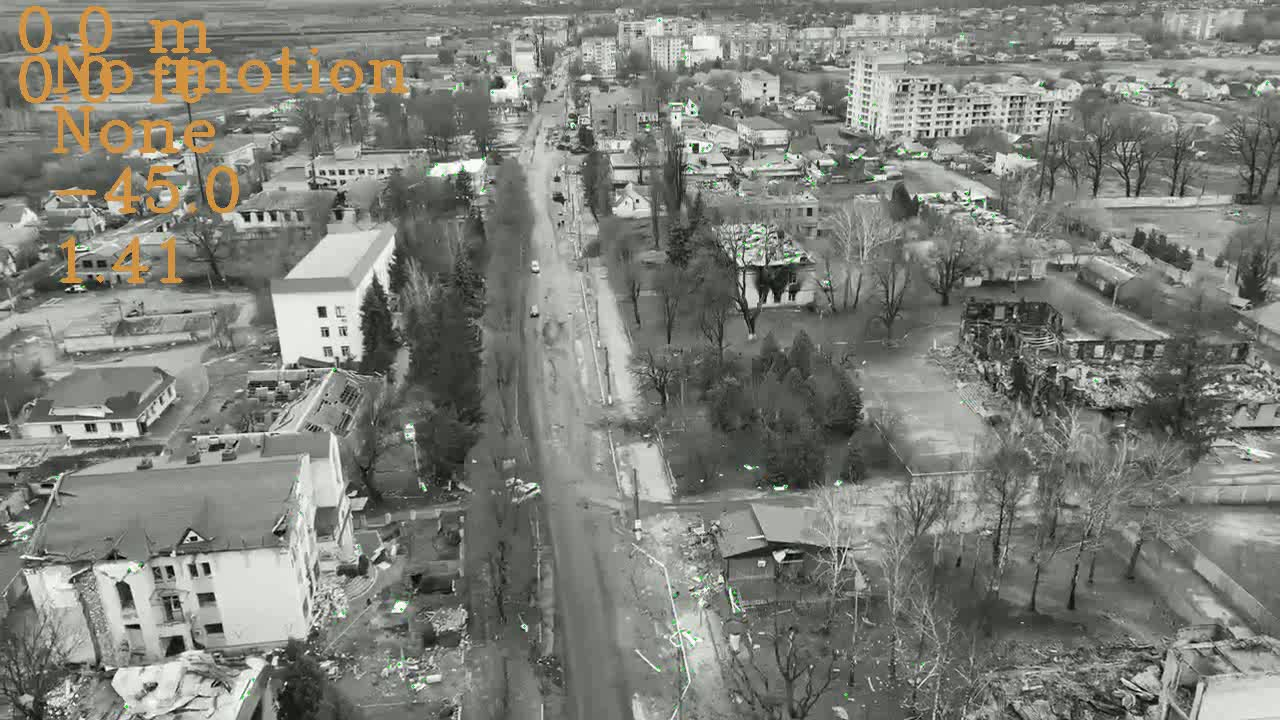

In [59]:
img1_pil

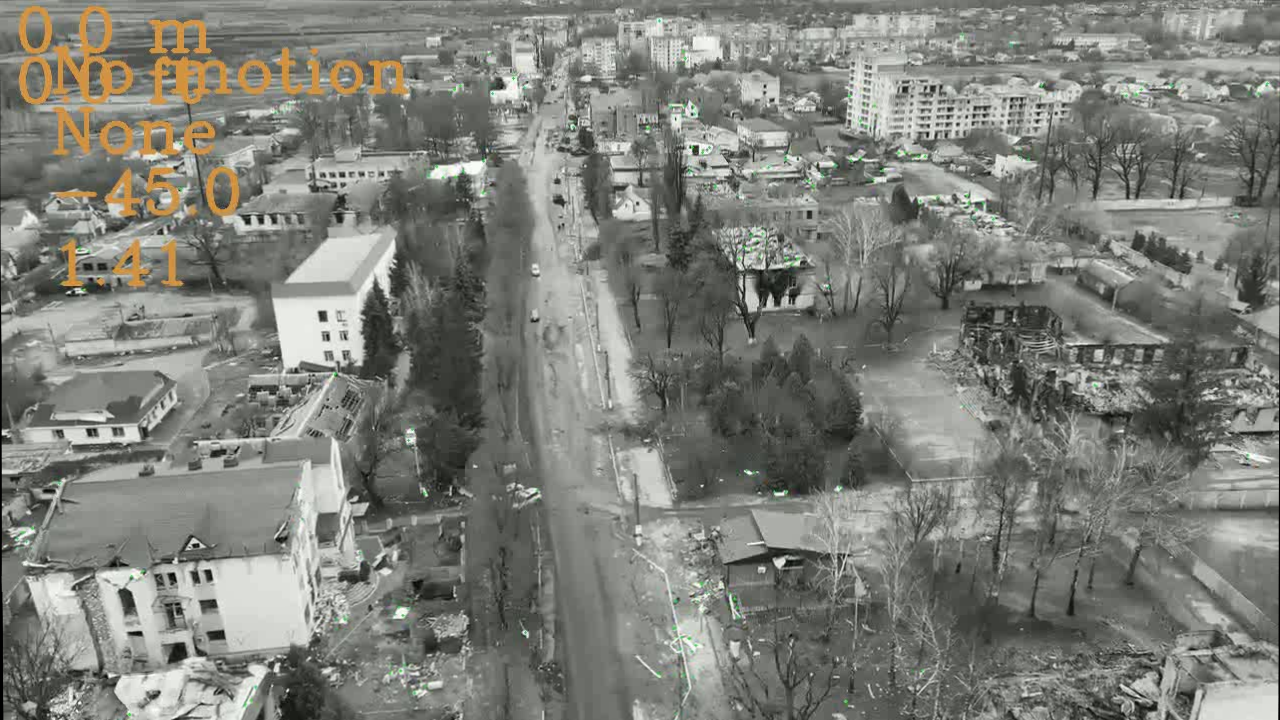

In [61]:
Image.fromarray(frame1_warped21)

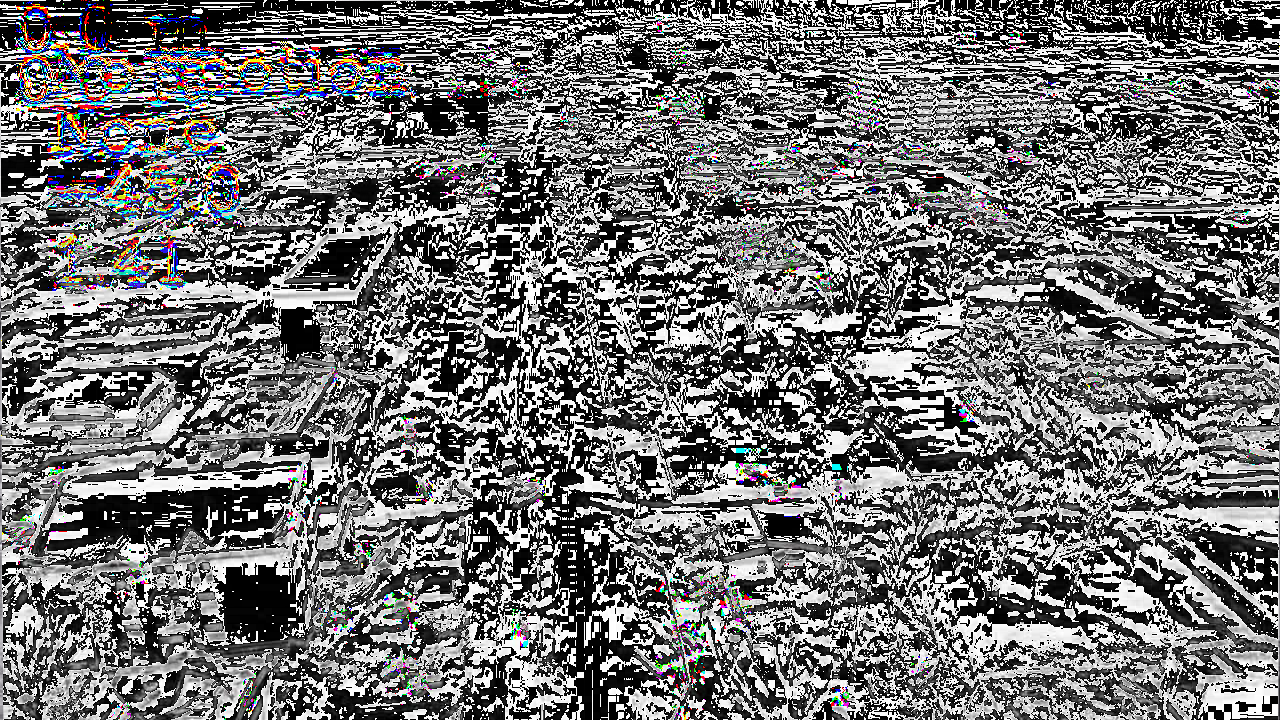

In [60]:
Image.fromarray(frame1_warped21 - frame1pil)

In [63]:
import webuiapi
api = webuiapi.WebUIApi(host='127.0.0.1', port=7860)

In [65]:
seed = 1234
prompt = 'Small american city, aerial view, high detailed'
negative_prompt = 'blurry, poor quality, cartoon'
ddim_steps = 20
scale = 7.0
strength = 0.3

In [70]:
from loguru import logger

## First version
```
frame1 -> img2img -> wrap ->
                             + -> blend
frame2 -> img2img ->
```

## Second version

```
frame1 -> img2img -> wrap ->

frame2 ->                    +  blend  -> img2img
```

TODO: try dynamic blend weight based of amount of moving in the frame

В случае когда камера почти не двигается, по сути много раз прогоняется в img2img один и тот же кадр и поэтому стилизация усиливается, а при возобновлении движения, степень стилизации резко падает

In [109]:
videoFramesFolder
use_controlnet = False

saving_folder = './result'
Path(saving_folder).mkdir(exist_ok=True)

DEBUG = True
prev = None
weights_path = None
blend = 0.5
check_consistency = True

# TODO: Batch processing
for i in range(len(imgs)):
    img_path = f"{videoFramesFolder}/{(i+1):04}.jpg"
    img_pil = Image.open(img_path)

    unit2 = webuiapi.ControlNetUnit(input_image=img_pil, module='depth', model='control_depth-fp16 [400750f6]', weight=1.0)
    controlnets = [unit2,] if use_controlnet else []
    
    height, width = img_arr.shape[:2]
    logger.info(f'Start inference with automatic API with next parameters:')
    logger.info(f'{prompt=}, {ddim_steps=}, {scale=}, {strength=}, {use_controlnet=}, {seed=}')
    logger.info(f'size = {width}x{height}')

    img2img_result = api.img2img(prompt=prompt,
                negative_prompt=negative_prompt,
                images=[img_pil], 
                width=width,
                height=height,
                # controlnet_units=[unit1, unit2],
                controlnet_units=controlnets,
                sampler_name="Euler a",
                steps=ddim_steps,
                cfg_scale=scale,
                seed=seed,
                eta=1.0,
                denoising_strength=strength,
            )
    
    if i == 0:
        img2img_result.image.save(saving_folder + f'/{(i+1):04}.png')
        prev = img2img_result.image
        continue
    
    flow_idx = f'{i:04}'
    flow1_path = f"{flo_folder}/{flow_idx}.jpg.npy"
    flow21 = np.load(flow1_path)
    
    img = img2img_result.image
    prev_arr = np.array(prev.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
    img_arr = np.array(img.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
    
    frame1_warped21 = warp_flow(prev_arr, flow21)
    
    weights_path = None
    if check_consistency: weights_path = f"{flo_folder}/{flow_idx}.jpg-21_cc.npy"
    print(weights_path)

    if weights_path: 
        forward_weights = load_cc(weights_path)
        blended_w = img_arr*(1-blend) + blend*(frame1_warped21*forward_weights+img_arr*(1-forward_weights))
    else: blended_w = img_arr*(1-blend) + frame1_warped21*(blend)

    blend_pil = PIL.Image.fromarray(blended_w.astype('uint8'))
    blend_pil.save(saving_folder + f'/{(i+1):04}.png')
    prev = blend_pil
    
    if i > 100:
        break

2023-03-31 02:53:32.773 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:32.774 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:32.774 | INFO     | __main__:<module>:24 - size = 1280x720
2023-03-31 02:53:36.885 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:36.886 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:36.887 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0001.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9920456069075171 0.05782979415635457


2023-03-31 02:53:40.541 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:40.542 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:40.543 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0002.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9890168168599658 0.08314716724330472


2023-03-31 02:53:44.223 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:44.224 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:44.224 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0003.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9160592891015302 0.2682781891149792


2023-03-31 02:53:47.949 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:47.949 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:47.950 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0004.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.8400183496969345 0.3597836764203335


2023-03-31 02:53:51.661 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:51.662 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:51.662 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0005.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.8886000978888327 0.30666763622440824


2023-03-31 02:53:55.407 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:55.408 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:55.408 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0006.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9470403999634217 0.2097879152477051


2023-03-31 02:53:59.126 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:53:59.127 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:53:59.128 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0007.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9956119570237939 0.04768014235186748


2023-03-31 02:54:02.839 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:02.840 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:02.841 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0008.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9967995851565197 0.033435412086801446


2023-03-31 02:54:06.564 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:06.565 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:06.565 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0009.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9263731256521744 0.25003189086036


2023-03-31 02:54:10.373 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:10.373 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:10.374 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0010.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9022359350861313 0.28833210069498355


2023-03-31 02:54:14.114 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:14.114 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:14.115 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0011.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9428225020712334 0.2191557965446278


2023-03-31 02:54:17.898 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:17.899 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:17.900 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0012.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9798036954311519 0.11975045837059814


2023-03-31 02:54:21.624 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:21.624 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:21.625 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0013.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9539624438287773 0.1898753516999685


2023-03-31 02:54:25.370 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:25.371 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:25.371 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0014.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9498760311140537 0.20317773713765883


2023-03-31 02:54:29.074 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:29.074 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:29.075 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0015.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.94263654540505 0.21743700171451985


2023-03-31 02:54:32.727 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:32.727 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:32.728 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0016.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.95403202334765 0.19224614997521533


2023-03-31 02:54:36.381 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:36.381 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:36.382 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0017.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9523968367477961 0.19350387912738823


2023-03-31 02:54:40.054 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:40.055 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:40.056 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0018.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9561284123498871 0.18519910964904274


2023-03-31 02:54:43.761 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:43.762 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:43.763 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0019.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9631443621068619 0.16588709809720775


2023-03-31 02:54:47.478 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:47.479 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:47.479 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0020.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9665656833895858 0.15595743193566788


2023-03-31 02:54:51.157 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:51.157 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:51.158 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0021.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9610644482049313 0.1743676519140172


2023-03-31 02:54:54.824 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:54.824 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:54.825 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0022.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9427903799622337 0.2185826421073872


2023-03-31 02:54:58.885 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:54:58.886 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:54:58.887 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0023.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9059658161456449 0.28357750381493774


2023-03-31 02:55:02.989 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:02.991 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:02.991 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0024.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9221553617015188 0.2577156658935283


2023-03-31 02:55:07.184 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:07.185 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:07.186 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0025.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9515432754140994 0.20198852661463929


2023-03-31 02:55:11.274 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:11.275 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:11.275 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0026.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.983259890084709 0.10715336353553669


2023-03-31 02:55:15.387 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:15.388 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:15.389 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0027.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9855906894178716 0.09969020551137477


2023-03-31 02:55:19.525 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:19.526 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:19.527 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0028.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9868963191488054 0.09110950126254279


2023-03-31 02:55:23.601 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:23.601 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:23.602 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0029.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9840245298811751 0.10162436998980086


2023-03-31 02:55:27.421 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:27.422 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:27.422 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0030.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9896196720427025 0.0772736470238235


2023-03-31 02:55:31.168 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:31.169 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:31.170 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0031.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9909589422851068 0.06704834562979331


2023-03-31 02:55:34.918 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:34.919 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:34.920 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0032.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886888692225392 0.08496352728460134


2023-03-31 02:55:38.641 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:38.642 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:38.642 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0033.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.988875698196148 0.08807045979745975


2023-03-31 02:55:42.378 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:42.379 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:42.379 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0034.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9862257776801239 0.0951987947800493


2023-03-31 02:55:46.168 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:46.169 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:46.169 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0035.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9851790759858957 0.10006001289390493


2023-03-31 02:55:50.311 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:50.312 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:50.312 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0036.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9855249057792346 0.09949492782832897


2023-03-31 02:55:54.901 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:54.902 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:54.902 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0037.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9757772960235377 0.13353620678953484


2023-03-31 02:55:59.374 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:55:59.375 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:55:59.375 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0038.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.953568644629713 0.19397610872670293


2023-03-31 02:56:03.645 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:03.646 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:03.646 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0039.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9496389893881143 0.20332325723214345


2023-03-31 02:56:07.899 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:07.900 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:07.900 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0040.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9521127472015725 0.19671459473483435


2023-03-31 02:56:12.193 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:12.194 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:12.195 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0041.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9818618605081678 0.10617417531453882


2023-03-31 02:56:16.737 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:16.738 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:16.739 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0042.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9891194297794903 0.07897452309506729


2023-03-31 02:56:21.301 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:21.302 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:21.303 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0043.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9913362756379741 0.06393519883889769


2023-03-31 02:56:25.361 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:25.361 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:25.362 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0044.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9874916662637881 0.08889305970138323


2023-03-31 02:56:29.135 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:29.136 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:29.136 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0045.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9873254129822041 0.08563557630426834


2023-03-31 02:56:32.912 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:32.913 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:32.913 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0046.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9893354295977468 0.07668184183511881


2023-03-31 02:56:36.771 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:36.772 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:36.772 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0047.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9861442297114636 0.08807608599031168


2023-03-31 02:56:47.925 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:47.926 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:47.926 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0048.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9879159006535102 0.08428838322522024


2023-03-31 02:56:51.627 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:51.628 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:51.628 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0049.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9871763536166539 0.09085673272192331


2023-03-31 02:56:55.348 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:55.349 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:55.349 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0050.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9891519733490907 0.07531327273436479


2023-03-31 02:56:59.074 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:56:59.075 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:56:59.075 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0051.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9882513070081869 0.0839245088255979


2023-03-31 02:57:02.797 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:02.798 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:02.798 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0052.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9904435631391071 0.065837714684376


2023-03-31 02:57:06.541 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:06.542 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:06.542 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0053.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9864404708936038 0.0912658635142384


2023-03-31 02:57:10.273 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:10.273 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:10.274 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0054.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9865078575754594 0.09142702764761626


2023-03-31 02:57:13.971 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:13.972 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:13.973 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0055.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886910104922718 0.08061415786367022


2023-03-31 02:57:17.693 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:17.693 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:17.694 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0056.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9862720814547742 0.0890384894309176


2023-03-31 02:57:21.509 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:21.510 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:21.510 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0057.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9872404491152917 0.08478265780515773


2023-03-31 02:57:25.257 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:25.258 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:25.259 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0058.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9877854852034721 0.08556756258799438


2023-03-31 02:57:29.019 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:29.020 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:29.020 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0059.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.98968896078047 0.07469363235130753


2023-03-31 02:57:32.696 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:32.697 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:32.697 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0060.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9897054071469493 0.07245387362196531


2023-03-31 02:57:36.369 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:36.370 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:36.370 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0061.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9869449162551022 0.08966252525485119


2023-03-31 02:57:40.045 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:40.046 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:40.047 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0062.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9878068398935554 0.08216695266925962


2023-03-31 02:57:43.711 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:43.712 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:43.713 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0063.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9869457716985811 0.08231956896272087


2023-03-31 02:57:47.390 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:47.390 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:47.391 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0064.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.985559765202798 0.0923154836328357


2023-03-31 02:57:51.072 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:51.073 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:51.074 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0065.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9879631547802816 0.08175756447586584


2023-03-31 02:57:54.744 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:54.744 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:54.745 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0066.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9874758730947852 0.08258721902437796


2023-03-31 02:57:58.424 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:57:58.425 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:57:58.425 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0067.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886222389642085 0.08027834438437033


2023-03-31 02:58:02.143 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:02.144 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:02.144 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0068.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9567914380715584 0.1862912568273347


2023-03-31 02:58:05.823 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:05.824 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:05.825 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0069.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9401206419174492 0.22504689542925269


2023-03-31 02:58:09.512 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:09.513 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:09.513 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0070.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9392741117417363 0.22755126234633444


2023-03-31 02:58:13.193 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:13.194 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:13.194 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0071.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9504391694560508 0.2037424174432801


2023-03-31 02:58:16.861 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:16.862 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:16.862 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0072.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9528934976426899 0.19768131400477182


2023-03-31 02:58:20.545 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:20.545 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:20.546 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0073.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9532718991470682 0.1984798808682173


2023-03-31 02:58:24.233 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:24.234 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:24.234 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0074.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9426938312038587 0.22151753101188243


2023-03-31 02:58:27.923 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:27.924 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:27.924 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0075.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9382939320396265 0.23064937645415345


2023-03-31 02:58:31.616 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:31.617 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:31.617 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0076.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9332135617542512 0.2387125003221083


2023-03-31 02:58:35.287 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:35.288 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:35.289 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0077.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9450459010847443 0.2164128060272701


2023-03-31 02:58:38.990 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:38.991 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:38.992 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0078.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9483771638686649 0.20945877624397488


2023-03-31 02:58:42.689 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:42.690 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:42.691 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0079.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.938148440744279 0.22829672483000885


2023-03-31 02:58:46.356 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:46.357 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:46.357 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0080.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9331520759048337 0.2376908095646027


2023-03-31 02:58:50.026 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:50.027 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:50.027 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0081.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9410902488090411 0.22470510364833454


2023-03-31 02:58:53.702 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:53.702 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:53.703 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0082.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9476479249824069 0.21131824951201245


2023-03-31 02:58:57.391 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:58:57.392 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:58:57.392 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0083.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9498117208341444 0.20674252758376832


2023-03-31 02:59:01.052 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:01.053 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:01.054 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0084.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9501665372844091 0.20615090220822282


2023-03-31 02:59:04.704 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:04.705 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:04.705 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0085.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9543401152050135 0.19723694771822442


2023-03-31 02:59:08.372 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:08.373 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:08.374 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0086.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9464966194978535 0.21145519165099147


2023-03-31 02:59:12.020 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:12.021 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:12.022 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0087.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9423194187190072 0.221612841405581


2023-03-31 02:59:15.676 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:15.676 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:15.677 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0088.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9550525906466336 0.1945255696765487


2023-03-31 02:59:19.342 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:19.343 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:19.343 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0089.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9579228758236271 0.1872837482928678


2023-03-31 02:59:23.008 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:23.009 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:23.009 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0090.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9620023996456498 0.17803383691930677


2023-03-31 02:59:26.655 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:26.656 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:26.657 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0091.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9620399554310218 0.17795173703465536


2023-03-31 02:59:30.323 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:30.324 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:30.324 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0092.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.952402707560238 0.19939448681946392


2023-03-31 02:59:33.967 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:33.968 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:33.969 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0093.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9567287459840217 0.18738205626706272


2023-03-31 02:59:37.634 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:37.635 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:37.636 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0094.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9851440995870621 0.09631056547259904


2023-03-31 02:59:41.289 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:41.290 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:41.290 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0095.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9746905255556626 0.13368468478301118


2023-03-31 02:59:44.939 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:44.939 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:44.940 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0096.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.965513546407082 0.16362119365248912


2023-03-31 02:59:48.606 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:48.607 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:48.607 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0097.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9600329377069583 0.17520469154006196


2023-03-31 02:59:52.265 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:52.266 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:52.267 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0098.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9660632472436188 0.16053287307518174


2023-03-31 02:59:55.930 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:55.930 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:55.931 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0099.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9786312485546244 0.1176734114895924


2023-03-31 02:59:59.572 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 02:59:59.573 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 02:59:59.573 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0100.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9785138060289557 0.11608728834679354


2023-03-31 03:00:03.228 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:00:03.229 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:00:03.230 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0101.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.970026010121008 0.1490195898431342


In [115]:
videoFramesFolder
use_controlnet = False

saving_folder = './result'
Path(saving_folder).mkdir(exist_ok=True)

DEBUG = True
prev = None
weights_path = None
blend = 0.5
check_consistency = True

# TODO: Batch processing
for i in range(len(imgs)):
    img_path = f"{videoFramesFolder}/{(i+1):04}.jpg"
    img_pil = Image.open(img_path)

    unit2 = webuiapi.ControlNetUnit(input_image=img_pil, module='depth', model='control_depth-fp16 [400750f6]', weight=1.0)
    controlnets = [unit2,] if use_controlnet else []
    
    height, width = img_arr.shape[:2]
    logger.info(f'Start inference with automatic API with next parameters:')
    logger.info(f'{prompt=}, {ddim_steps=}, {scale=}, {strength=}, {use_controlnet=}, {seed=}')
    logger.info(f'size = {width}x{height}')
    
    if i == 0:
        img2img_result = api.img2img(prompt=prompt,
                negative_prompt=negative_prompt,
                images=[img_pil], 
                width=width,
                height=height,
                # controlnet_units=[unit1, unit2],
                controlnet_units=controlnets,
                sampler_name="Euler a",
                steps=ddim_steps,
                cfg_scale=scale,
                seed=seed,
                eta=1.0,
                denoising_strength=strength,
            )
        
        img2img_result.image.save(saving_folder + f'/{(i+1):04}.png')
        prev = img2img_result.image
        continue
    
    flow_idx = f'{i:04}'
    flow1_path = f"{flo_folder}/{flow_idx}.jpg.npy"
    flow21 = np.load(flow1_path)
    
#     img = img2img_result.image
    prev_arr = np.array(prev.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
    img_arr = np.array(img_pil.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
    
    frame1_warped21 = warp_flow(prev_arr, flow21)
    
    weights_path = None
    if check_consistency: weights_path = f"{flo_folder}/{flow_idx}.jpg-21_cc.npy"
    print(weights_path)

    if weights_path: 
        forward_weights = load_cc(weights_path)
        blended_w = img_arr*(1-blend) + blend*(frame1_warped21*forward_weights+img_arr*(1-forward_weights))
    else: blended_w = img_arr*(1-blend) + frame1_warped21*(blend)

    blend_pil = PIL.Image.fromarray(blended_w.astype('uint8'))
    
    img2img_result = api.img2img(prompt=prompt,
        negative_prompt=negative_prompt,
        images=[blend_pil], 
        width=width,
        height=height,
        # controlnet_units=[unit1, unit2],
        controlnet_units=controlnets,
        sampler_name="Euler a",
        steps=ddim_steps,
        cfg_scale=scale,
        seed=seed,
        eta=1.0,
        denoising_strength=strength,
    )
    blend_pil = img2img_result.image
    blend_pil.save(saving_folder + f'/{(i+1):04}.png')
    prev = blend_pil
    
#     if i > 100:
#         break

2023-03-31 03:26:32.664 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:32.664 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:32.665 | INFO     | __main__:<module>:24 - size = 1280x720
2023-03-31 03:26:36.615 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:36.616 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:36.617 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0001.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9920456069075171 0.05782979415635457


2023-03-31 03:26:40.366 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:40.367 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:40.368 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0002.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9890168168599658 0.08314716724330472


2023-03-31 03:26:44.111 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:44.111 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:44.112 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0003.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9160592891015302 0.2682781891149792


2023-03-31 03:26:47.932 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:47.933 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:47.933 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0004.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.8400183496969345 0.3597836764203335


2023-03-31 03:26:51.740 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:51.740 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:51.741 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0005.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.8886000978888327 0.30666763622440824


2023-03-31 03:26:55.562 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:55.563 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:55.563 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0006.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9470403999634217 0.2097879152477051


2023-03-31 03:26:59.415 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:26:59.415 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:26:59.416 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0007.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9956119570237939 0.04768014235186748


2023-03-31 03:27:03.317 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:03.317 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:03.318 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0008.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9967995851565197 0.033435412086801446


2023-03-31 03:27:07.352 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:07.353 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:07.353 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0009.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9263731256521744 0.25003189086036


2023-03-31 03:27:11.206 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:11.207 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:11.207 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0010.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9022359350861313 0.28833210069498355


2023-03-31 03:27:15.273 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:15.273 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:15.274 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0011.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9428225020712334 0.2191557965446278


2023-03-31 03:27:19.165 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:19.166 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:19.167 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0012.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9798036954311519 0.11975045837059814


2023-03-31 03:27:22.985 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:22.986 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:22.986 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0013.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9539624438287773 0.1898753516999685


2023-03-31 03:27:26.798 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:26.798 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:26.799 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0014.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9498760311140537 0.20317773713765883


2023-03-31 03:27:30.617 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:30.618 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:30.619 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0015.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.94263654540505 0.21743700171451985


2023-03-31 03:27:34.419 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:34.419 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:34.420 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0016.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.95403202334765 0.19224614997521533


2023-03-31 03:27:38.202 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:38.203 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:38.203 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0017.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9523968367477961 0.19350387912738823


2023-03-31 03:27:41.995 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:41.996 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:41.996 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0018.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9561284123498871 0.18519910964904274


2023-03-31 03:27:45.779 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:45.780 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:45.781 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0019.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9631443621068619 0.16588709809720775


2023-03-31 03:27:49.606 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:49.607 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:49.607 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0020.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9665656833895858 0.15595743193566788


2023-03-31 03:27:53.397 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:53.398 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:53.398 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0021.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9610644482049313 0.1743676519140172


2023-03-31 03:27:57.227 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:27:57.228 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:27:57.229 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0022.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9427903799622337 0.2185826421073872


2023-03-31 03:28:01.086 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:01.087 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:01.087 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0023.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9059658161456449 0.28357750381493774


2023-03-31 03:28:04.873 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:04.874 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:04.874 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0024.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9221553617015188 0.2577156658935283


2023-03-31 03:28:08.704 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:08.705 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:08.705 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0025.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9515432754140994 0.20198852661463929


2023-03-31 03:28:12.538 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:12.539 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:12.540 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0026.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.983259890084709 0.10715336353553669


2023-03-31 03:28:16.390 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:16.390 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:16.391 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0027.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9855906894178716 0.09969020551137477


2023-03-31 03:28:20.218 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:20.219 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:20.219 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0028.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9868963191488054 0.09110950126254279


2023-03-31 03:28:24.031 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:24.032 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:24.033 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0029.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9840245298811751 0.10162436998980086


2023-03-31 03:28:27.833 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:27.833 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:27.833 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0030.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9896196720427025 0.0772736470238235


2023-03-31 03:28:31.631 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:31.632 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:31.632 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0031.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9909589422851068 0.06704834562979331


2023-03-31 03:28:35.449 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:35.450 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:35.450 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0032.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886888692225392 0.08496352728460134


2023-03-31 03:28:39.250 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:39.251 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:39.251 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0033.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.988875698196148 0.08807045979745975


2023-03-31 03:28:43.054 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:43.055 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:43.055 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0034.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9862257776801239 0.0951987947800493


2023-03-31 03:28:46.867 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:46.868 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:46.868 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0035.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9851790759858957 0.10006001289390493


2023-03-31 03:28:50.726 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:50.726 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:50.727 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0036.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9855249057792346 0.09949492782832897


2023-03-31 03:28:54.542 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:54.543 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:54.544 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0037.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9757772960235377 0.13353620678953484


2023-03-31 03:28:58.378 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:28:58.378 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:28:58.379 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0038.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.953568644629713 0.19397610872670293


2023-03-31 03:29:02.224 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:02.225 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:02.225 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0039.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9496389893881143 0.20332325723214345


2023-03-31 03:29:06.090 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:06.091 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:06.091 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0040.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9521127472015725 0.19671459473483435


2023-03-31 03:29:09.948 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:09.949 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:09.949 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0041.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9818618605081678 0.10617417531453882


2023-03-31 03:29:13.804 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:13.804 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:13.805 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0042.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9891194297794903 0.07897452309506729


2023-03-31 03:29:17.660 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:17.660 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:17.661 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0043.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9913362756379741 0.06393519883889769


2023-03-31 03:29:21.509 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:21.510 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:21.511 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0044.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9874916662637881 0.08889305970138323


2023-03-31 03:29:25.341 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:25.342 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:25.342 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0045.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9873254129822041 0.08563557630426834


2023-03-31 03:29:29.181 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:29.181 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:29.182 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0046.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9893354295977468 0.07668184183511881


2023-03-31 03:29:33.015 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:33.015 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:33.016 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0047.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9861442297114636 0.08807608599031168


2023-03-31 03:29:36.859 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:36.859 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:36.860 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0048.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9879159006535102 0.08428838322522024


2023-03-31 03:29:40.690 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:40.690 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:40.691 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0049.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9871763536166539 0.09085673272192331


2023-03-31 03:29:44.522 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:44.522 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:44.523 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0050.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9891519733490907 0.07531327273436479


2023-03-31 03:29:48.364 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:48.365 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:48.365 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0051.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9882513070081869 0.0839245088255979


2023-03-31 03:29:52.187 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:52.188 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:52.189 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0052.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9904435631391071 0.065837714684376


2023-03-31 03:29:56.005 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:56.005 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:56.006 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0053.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9864404708936038 0.0912658635142384


2023-03-31 03:29:59.827 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:29:59.828 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:29:59.829 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0054.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9865078575754594 0.09142702764761626


2023-03-31 03:30:03.627 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:03.628 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:03.628 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0055.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886910104922718 0.08061415786367022


2023-03-31 03:30:07.416 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:07.417 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:07.417 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0056.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9862720814547742 0.0890384894309176


2023-03-31 03:30:11.196 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:11.196 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:11.197 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0057.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9872404491152917 0.08478265780515773


2023-03-31 03:30:14.947 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:14.948 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:14.949 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0058.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9877854852034721 0.08556756258799438


2023-03-31 03:30:18.707 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:18.708 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:18.709 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0059.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.98968896078047 0.07469363235130753


2023-03-31 03:30:22.409 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:22.410 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:22.410 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0060.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9897054071469493 0.07245387362196531


2023-03-31 03:30:26.107 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:26.108 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:26.109 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0061.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9869449162551022 0.08966252525485119


2023-03-31 03:30:29.811 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:29.812 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:29.813 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0062.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9878068398935554 0.08216695266925962


2023-03-31 03:30:33.484 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:33.485 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:33.485 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0063.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9869457716985811 0.08231956896272087


2023-03-31 03:30:37.169 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:37.170 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:37.171 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0064.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.985559765202798 0.0923154836328357


2023-03-31 03:30:40.864 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:40.864 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:40.865 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0065.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9879631547802816 0.08175756447586584


2023-03-31 03:30:44.527 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:44.528 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:44.528 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0066.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9874758730947852 0.08258721902437796


2023-03-31 03:30:48.167 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:48.168 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:48.168 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0067.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9886222389642085 0.08027834438437033


2023-03-31 03:30:51.840 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:51.841 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:51.842 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0068.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9567914380715584 0.1862912568273347


2023-03-31 03:30:55.555 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:55.555 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:55.556 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0069.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9401206419174492 0.22504689542925269


2023-03-31 03:30:59.333 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:30:59.333 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:30:59.334 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0070.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9392741117417363 0.22755126234633444


2023-03-31 03:31:03.151 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:03.151 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:03.152 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0071.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9504391694560508 0.2037424174432801


2023-03-31 03:31:07.026 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:07.027 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:07.027 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0072.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9528934976426899 0.19768131400477182


2023-03-31 03:31:10.901 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:10.902 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:10.903 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0073.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9532718991470682 0.1984798808682173


2023-03-31 03:31:14.771 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:14.772 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:14.772 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0074.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9426938312038587 0.22151753101188243


2023-03-31 03:31:18.647 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:18.648 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:18.648 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0075.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9382939320396265 0.23064937645415345


2023-03-31 03:31:22.501 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:22.502 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:22.502 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0076.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9332135617542512 0.2387125003221083


2023-03-31 03:31:26.323 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:26.324 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:26.324 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0077.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9450459010847443 0.2164128060272701


2023-03-31 03:31:30.157 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:30.157 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:30.158 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0078.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9483771638686649 0.20945877624397488


2023-03-31 03:31:33.991 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:33.992 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:33.992 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0079.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.938148440744279 0.22829672483000885


2023-03-31 03:31:37.786 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:37.787 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:37.787 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0080.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9331520759048337 0.2376908095646027


2023-03-31 03:31:41.576 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:41.576 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:41.577 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0081.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9410902488090411 0.22470510364833454


2023-03-31 03:31:45.369 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:45.369 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:45.370 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0082.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9476479249824069 0.21131824951201245


2023-03-31 03:31:49.186 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:49.187 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:49.187 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0083.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9498117208341444 0.20674252758376832


2023-03-31 03:31:52.976 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:52.976 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:52.977 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0084.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9501665372844091 0.20615090220822282


2023-03-31 03:31:56.735 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:31:56.736 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:31:56.736 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0085.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9543401152050135 0.19723694771822442


2023-03-31 03:32:00.500 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:00.500 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:00.501 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0086.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9464966194978535 0.21145519165099147


2023-03-31 03:32:04.266 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:04.267 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:04.267 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0087.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9423194187190072 0.221612841405581


2023-03-31 03:32:08.031 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:08.032 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:08.032 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0088.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9550525906466336 0.1945255696765487


2023-03-31 03:32:11.825 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:11.826 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:11.826 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0089.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9579228758236271 0.1872837482928678


2023-03-31 03:32:15.634 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:15.634 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:15.635 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0090.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9620023996456498 0.17803383691930677


2023-03-31 03:32:19.444 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:19.445 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:19.445 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0091.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9620399554310218 0.17795173703465536


2023-03-31 03:32:23.245 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:23.245 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:23.246 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0092.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.952402707560238 0.19939448681946392


2023-03-31 03:32:27.034 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:27.035 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:27.035 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0093.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9567287459840217 0.18738205626706272


2023-03-31 03:32:30.829 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:30.830 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:30.830 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0094.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9851440995870621 0.09631056547259904


2023-03-31 03:32:34.620 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:34.621 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:34.621 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0095.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9746905255556626 0.13368468478301118


2023-03-31 03:32:38.406 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:38.407 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:38.407 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0096.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.965513546407082 0.16362119365248912


2023-03-31 03:32:42.200 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:42.201 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:42.201 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0097.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9600329377069583 0.17520469154006196


2023-03-31 03:32:45.989 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:45.989 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:45.990 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0098.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9660632472436188 0.16053287307518174


2023-03-31 03:32:49.776 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:49.777 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:49.777 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0099.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9786312485546244 0.1176734114895924


2023-03-31 03:32:53.542 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:53.543 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:53.543 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0100.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9785138060289557 0.11608728834679354


2023-03-31 03:32:57.301 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:32:57.302 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:32:57.302 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0101.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.970026010121008 0.1490195898431342


2023-03-31 03:33:01.069 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:01.070 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:01.071 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0102.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9615701191320923 0.17222732644896874


2023-03-31 03:33:04.815 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:04.815 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:04.816 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0103.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9470330561344592 0.20935993331677408


2023-03-31 03:33:08.586 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:08.587 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:08.588 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0104.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9461255605965057 0.21160959224234227


2023-03-31 03:33:12.366 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:12.367 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:12.368 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0105.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9565088667068915 0.18802972383382188


2023-03-31 03:33:16.169 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:16.170 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:16.170 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0106.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9547327800431719 0.19106967395887434


2023-03-31 03:33:19.986 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:19.987 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:19.987 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0107.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9470568287618483 0.208820006762954


2023-03-31 03:33:23.801 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:23.802 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:23.803 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0108.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9532349403544904 0.19603633478063417


2023-03-31 03:33:27.640 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:27.640 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:27.641 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0109.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9435545832195075 0.21707432393170334


2023-03-31 03:33:31.480 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:31.481 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:31.481 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0110.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9511753082104611 0.20050635194106664


2023-03-31 03:33:35.313 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:35.313 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:35.314 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0111.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9556325603346055 0.18981477653684103


2023-03-31 03:33:39.136 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:39.136 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:39.137 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0112.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9535626805464974 0.1947394681226957


2023-03-31 03:33:42.956 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:42.957 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:42.957 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0113.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9563109798703143 0.1892811918411335


2023-03-31 03:33:46.805 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:46.806 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:46.806 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0114.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9488038869604144 0.20537819285339212


2023-03-31 03:33:50.658 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:50.659 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:50.659 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0115.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.93295855099539 0.23663792940869963


2023-03-31 03:33:54.509 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:54.510 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:54.511 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0116.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9323584234603964 0.23859011118805157


2023-03-31 03:33:58.369 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:33:58.370 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:33:58.371 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0117.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9494013455449677 0.20401322884772777


2023-03-31 03:34:02.235 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:02.236 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:02.236 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0118.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9539327000824015 0.1913879155147779


2023-03-31 03:34:06.085 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:06.086 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:06.087 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0119.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9658972578345828 0.16178775432309828


2023-03-31 03:34:09.924 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:09.925 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:09.926 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0120.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9587360390907174 0.18040991821360472


2023-03-31 03:34:13.778 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:13.779 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:13.779 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0121.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9591174421990716 0.1796045063603127


2023-03-31 03:34:17.622 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:17.623 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:17.623 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0122.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9457899858784246 0.212493515519976


2023-03-31 03:34:21.464 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:21.464 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:21.465 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0123.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9456439695249242 0.21283516156638319


2023-03-31 03:34:25.307 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:25.307 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:25.308 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0124.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9618263302668454 0.173208358262951


2023-03-31 03:34:29.153 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:29.154 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:29.155 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0125.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9656987330903688 0.16108388736615548


2023-03-31 03:34:33.000 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:33.001 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:33.001 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0126.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.953970368800066 0.19483561199858093


2023-03-31 03:34:36.843 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:36.844 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:36.845 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0127.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9546701699336011 0.19376406031600416


2023-03-31 03:34:40.685 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:40.686 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:40.686 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0128.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9472228961447908 0.21011005768683616


2023-03-31 03:34:44.533 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:44.534 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:44.534 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0129.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9540642263728912 0.1947881793185292


2023-03-31 03:34:48.408 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:48.409 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:48.410 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0130.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9597552769629181 0.1801257398804587


2023-03-31 03:34:52.437 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:52.438 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:52.438 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0131.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9650046435638879 0.16691635108442274


2023-03-31 03:34:56.311 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:34:56.311 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:34:56.312 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0132.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9656202921446679 0.16038245405111207


2023-03-31 03:35:00.176 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:00.176 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:00.177 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0133.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9721987171838403 0.13839937860956722


2023-03-31 03:35:04.030 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:04.031 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:04.031 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0134.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9713720615952977 0.13994808084246815


2023-03-31 03:35:07.878 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:07.879 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:07.880 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0135.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9800104105074132 0.11044057477783704


2023-03-31 03:35:11.731 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:11.731 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:11.732 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0136.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.973677274830433 0.13440786188396556


2023-03-31 03:35:15.595 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:15.596 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:15.597 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0137.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9585045431531554 0.18378583508399204


2023-03-31 03:35:19.464 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:19.465 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:19.465 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0138.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9515856467953006 0.20017502099447093


2023-03-31 03:35:23.336 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:23.336 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:23.337 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0139.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9507085941034857 0.20078375174276009


2023-03-31 03:35:27.201 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:27.201 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:27.202 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0140.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9623208096925329 0.17401697647767164


2023-03-31 03:35:31.071 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:31.071 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:31.072 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0141.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9772865614388847 0.12316471304401312


2023-03-31 03:35:34.939 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:34.940 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:34.940 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0142.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9781253592727014 0.12136148158187679


2023-03-31 03:35:38.799 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:38.799 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:38.800 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0143.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9788077608891581 0.11660269716197336


2023-03-31 03:35:42.648 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:42.649 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:42.650 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0144.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9712072196386045 0.14730001532060474


2023-03-31 03:35:46.493 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:46.493 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:46.494 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0145.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9554351087760048 0.1906225584985245


2023-03-31 03:35:50.349 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:50.350 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:50.350 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0146.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9550973427600163 0.1906329596845132


2023-03-31 03:35:54.221 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:54.222 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:54.222 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0147.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9603819080731915 0.1784635533193341


2023-03-31 03:35:58.146 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:35:58.147 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:35:58.148 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0148.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9599829913646243 0.17773937612598126


2023-03-31 03:36:02.035 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:02.035 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:02.036 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0149.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9609295601445186 0.17386625094499078


2023-03-31 03:36:05.872 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:05.872 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:05.873 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0150.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9591768315894594 0.1782360003564681


2023-03-31 03:36:09.712 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:09.713 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:09.714 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0151.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9613684799073917 0.1714829080863018


2023-03-31 03:36:13.663 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:13.664 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:13.665 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0152.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9611569890054489 0.17351431300832637


2023-03-31 03:36:17.617 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:17.618 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:17.618 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0153.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9599843497360833 0.17466135735856367


2023-03-31 03:36:21.510 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:21.511 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:21.511 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0154.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9578844702863415 0.18171294085731982


2023-03-31 03:36:25.355 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:25.356 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:25.357 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0155.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.955048448037405 0.18876297783548232


2023-03-31 03:36:29.174 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:29.175 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:29.175 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0156.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9569066919303042 0.18471880220516157


2023-03-31 03:36:32.993 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:32.993 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:32.994 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0157.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9536446627470084 0.193722481306854


2023-03-31 03:36:36.830 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:36.831 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:36.831 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0158.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9540293895762746 0.19367562786436388


2023-03-31 03:36:40.680 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:40.681 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:40.682 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0159.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9535796539926563 0.19341538696617616


2023-03-31 03:36:44.593 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:44.594 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:44.594 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0160.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.953961225442165 0.1914491102268686


2023-03-31 03:36:48.438 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:48.439 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:48.440 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0161.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9543628222774756 0.190962599277574


2023-03-31 03:36:52.286 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:52.286 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:52.287 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0162.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9531573525427134 0.19480168528679276


2023-03-31 03:36:56.119 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:56.120 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:56.121 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0163.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9555097323352538 0.18760359979131166


2023-03-31 03:36:59.964 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:36:59.965 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:36:59.966 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0164.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.960074027391165 0.1766107065119021


2023-03-31 03:37:03.814 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:03.815 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:03.815 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0165.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9575188675060333 0.18232143417874264


2023-03-31 03:37:07.668 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:07.669 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:07.669 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0166.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9563601820972868 0.18480772884107846


2023-03-31 03:37:11.528 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:11.529 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:11.529 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0167.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9577519903474232 0.1822731194580443


2023-03-31 03:37:15.394 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:15.394 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:15.395 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0168.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9609795805864441 0.17326161013381267


2023-03-31 03:37:19.255 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:19.255 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:19.256 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0169.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9615647655197581 0.16996372116267183


2023-03-31 03:37:23.118 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:23.119 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:23.119 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0170.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.960821136682444 0.17269384158660872


2023-03-31 03:37:26.988 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:26.989 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:26.989 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0171.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9575983876141362 0.18108291962718015


2023-03-31 03:37:30.871 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:30.871 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:30.872 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0172.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9611633250401573 0.17136803012707988


2023-03-31 03:37:34.721 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:34.722 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:34.722 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0173.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9561185573426702 0.1860142673881404


2023-03-31 03:37:38.556 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:38.556 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:38.557 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0174.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9580021953892268 0.1811174166207919


2023-03-31 03:37:42.448 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:42.449 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:42.450 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0175.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9602841000809327 0.17568839357306035


2023-03-31 03:37:46.330 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:46.331 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:46.331 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0176.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9620342197027845 0.17128124725390667


2023-03-31 03:37:50.165 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:50.166 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:50.166 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0177.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9605421930519852 0.17444408445317447


2023-03-31 03:37:54.102 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:54.102 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:54.103 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0178.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9504735517138213 0.20229511324902125


2023-03-31 03:37:57.996 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:37:57.997 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:37:57.997 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0179.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9419175597910195 0.22062456308165082


2023-03-31 03:38:01.883 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:01.883 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:01.884 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0180.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9444306226560827 0.2169688703102466


2023-03-31 03:38:05.769 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:05.770 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:05.770 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0181.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9471015228890708 0.2109140392772083


2023-03-31 03:38:09.659 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:09.660 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:09.660 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0182.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9549541975700772 0.19413492760869136


2023-03-31 03:38:13.534 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:13.535 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:13.535 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0183.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9452379345121384 0.21522041099790432


2023-03-31 03:38:17.424 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:17.425 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:17.425 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0184.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9483576626130251 0.20733341659823945


2023-03-31 03:38:21.274 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:21.274 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:21.275 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0185.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9538406399309781 0.19663651911078836


2023-03-31 03:38:25.125 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:25.125 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:25.126 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0186.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9446956351373538 0.2154695569718277


2023-03-31 03:38:28.967 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:28.968 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:28.968 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0187.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.949529864486978 0.2035714271700227


2023-03-31 03:38:32.793 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:32.793 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:32.794 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0188.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9506904378193057 0.20369422085468308


2023-03-31 03:38:36.621 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:36.621 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:36.622 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0189.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9527317013143392 0.1982347314271179


2023-03-31 03:38:40.443 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:40.444 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:40.445 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0190.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.947995467295743 0.20920807064675648


2023-03-31 03:38:44.281 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:44.281 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:44.282 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0191.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9486134473815548 0.20753106420691872


2023-03-31 03:38:48.115 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:48.116 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:48.116 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0192.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9481889395000687 0.20749365959571767


2023-03-31 03:38:51.950 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:51.951 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:51.951 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0193.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9452394416912564 0.21446830658206054


2023-03-31 03:38:55.809 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:55.810 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:55.810 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0194.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.944358461541213 0.21650182292201417


2023-03-31 03:38:59.665 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:38:59.666 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:38:59.666 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0195.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9390529777358867 0.22580955065950814


2023-03-31 03:39:03.510 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:03.510 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:03.511 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0196.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9396729884041676 0.22357096864934498


2023-03-31 03:39:07.378 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:07.379 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:07.380 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0197.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.942703955664766 0.21797321932558703


2023-03-31 03:39:11.222 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:11.223 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:11.223 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0198.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9436480317269266 0.2165636582262232


2023-03-31 03:39:15.061 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:15.062 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:15.063 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0199.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9544733739435676 0.19319278443886298


2023-03-31 03:39:18.901 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:18.902 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:18.902 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0200.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9767669970310521 0.1293465824238727


2023-03-31 03:39:22.768 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:22.769 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:22.770 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0201.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9546704445961302 0.1927266520188498


2023-03-31 03:39:26.614 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:26.615 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:26.616 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0202.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9405311622401094 0.22468505744943948


2023-03-31 03:39:30.455 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:30.456 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:30.456 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0203.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.93769450386341 0.2298969401352989


2023-03-31 03:39:34.339 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:34.340 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:34.341 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0204.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9479798017203107 0.20785586488665497


2023-03-31 03:39:38.185 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:38.186 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:38.187 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0205.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9529393428669807 0.1962347984788362


2023-03-31 03:39:42.030 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:42.030 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:42.031 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0206.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9510718298096865 0.1988236353236947


2023-03-31 03:39:45.880 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:45.880 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:45.881 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0207.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9432067994159934 0.21669098475565818


2023-03-31 03:39:49.708 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:49.709 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:49.710 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0208.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9432839955858774 0.2163578790751429


2023-03-31 03:39:53.575 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:53.576 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:53.577 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0209.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9452312075423568 0.21478039021284548


2023-03-31 03:39:57.423 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:39:57.424 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:39:57.424 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0210.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9492164054230333 0.20418212846500347


2023-03-31 03:40:01.261 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:01.261 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:01.262 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0211.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9525385299917688 0.19622159786099935


2023-03-31 03:40:05.095 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:05.096 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:05.096 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0212.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.953208693611147 0.1965535457710681


2023-03-31 03:40:08.924 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:08.925 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:08.925 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0213.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9615561516788845 0.17235264750262214


2023-03-31 03:40:12.732 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:12.732 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:12.733 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0214.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9572307794912459 0.18497739390196846


2023-03-31 03:40:16.533 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:16.534 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:16.535 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0215.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9514212716285686 0.19842568614650502


2023-03-31 03:40:20.347 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:20.348 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:20.349 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0216.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9515266795341053 0.19866291499298613


2023-03-31 03:40:24.141 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:24.142 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:24.143 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0217.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9454083202061603 0.2132207067283052


2023-03-31 03:40:27.939 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:27.940 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:27.941 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0218.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9482262724125036 0.20835959137697968


2023-03-31 03:40:31.764 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:31.765 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:31.766 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0219.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.955916973228587 0.18954296627294873


2023-03-31 03:40:35.605 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:35.606 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:35.607 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0220.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9570322336344371 0.1857175126000397


2023-03-31 03:40:39.438 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:39.439 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:39.439 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0221.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9490578406887318 0.20424228331115743


2023-03-31 03:40:43.264 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:43.265 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:43.265 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0222.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9542581432952151 0.19287462134997405


2023-03-31 03:40:47.072 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:47.072 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:47.073 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0223.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9595879865414577 0.17755775331102452


2023-03-31 03:40:50.872 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:50.872 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:50.873 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0224.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9481394915976749 0.20783768655176205


2023-03-31 03:40:54.724 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:54.725 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:54.725 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0225.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9426563368752883 0.21966963183156235


2023-03-31 03:40:58.514 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:40:58.515 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:40:58.515 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0226.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9410725800642423 0.22195916384491043


2023-03-31 03:41:02.295 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:02.295 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:02.296 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0227.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9411338310549401 0.22243704081196708


2023-03-31 03:41:06.075 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:06.076 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:06.077 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0228.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9436106074978444 0.21791473518738477


2023-03-31 03:41:09.838 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:09.839 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:09.839 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0229.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9495412522232755 0.20378636081208623


2023-03-31 03:41:13.617 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:13.618 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:13.618 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0230.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9570187689277142 0.1843837345923653


2023-03-31 03:41:17.405 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:17.406 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:17.407 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0231.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9554833750644302 0.190116583768268


2023-03-31 03:41:21.197 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:21.198 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:21.198 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0232.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9590034517475381 0.17923734558383195


2023-03-31 03:41:25.053 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:25.054 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:25.055 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0233.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9704517124337368 0.14174161260926188


2023-03-31 03:41:28.866 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:28.866 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:28.867 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0234.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9554813306032036 0.18845564435214537


2023-03-31 03:41:32.651 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:32.651 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:32.652 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0235.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9512662828429531 0.2000791853611398


2023-03-31 03:41:36.440 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:36.441 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:36.441 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0236.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9546434456555113 0.19356237413466468


2023-03-31 03:41:40.225 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:40.226 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:40.226 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0237.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9571771598068746 0.18547390955291743


2023-03-31 03:41:44.016 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:44.017 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:44.017 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0238.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9511574560930142 0.2019400855347678


2023-03-31 03:41:47.818 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:47.819 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:47.820 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0239.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9562430451275279 0.18656031012632188


2023-03-31 03:41:51.601 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:51.602 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:51.602 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0240.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9564005841391252 0.18640575178732316


2023-03-31 03:41:55.419 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:55.420 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:55.421 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0241.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9615951042820448 0.17278096206814483


2023-03-31 03:41:59.231 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:41:59.231 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:41:59.232 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0242.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9538488209363023 0.19315801130827998


2023-03-31 03:42:03.052 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:03.052 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:03.053 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0243.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9516672428331633 0.19845130656905158


2023-03-31 03:42:06.876 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:06.877 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:06.877 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0244.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9516336083783147 0.1990246770717115


2023-03-31 03:42:10.723 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:10.723 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:10.724 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0245.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9552781035082495 0.1886298503939909


2023-03-31 03:42:14.574 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:14.575 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:14.575 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0246.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9587924090517722 0.18012554563532862


2023-03-31 03:42:18.449 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:18.450 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:18.450 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0247.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9489653113187951 0.20525411336158464


2023-03-31 03:42:22.317 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:22.317 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:22.318 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0248.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9465606987698137 0.21020829103172275


2023-03-31 03:42:26.182 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:26.183 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:26.183 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0249.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9598559505635189 0.17545031140368011


2023-03-31 03:42:30.041 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:30.042 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:30.042 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0250.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9770407596969315 0.12087402864108096


2023-03-31 03:42:33.925 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:33.926 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:33.926 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0251.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9803908022102095 0.11564243080444879


2023-03-31 03:42:37.806 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:37.807 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:37.807 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0252.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9369899523883976 0.23271028786561493


2023-03-31 03:42:41.665 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:41.666 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:41.666 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0253.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9242782765793544 0.2549344758084927


2023-03-31 03:42:45.500 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:45.501 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:45.501 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0254.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.920061801933887 0.26218131078051626


2023-03-31 03:42:49.315 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:49.316 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:49.317 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0255.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9243582770777272 0.2553111238139593


2023-03-31 03:42:53.105 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:53.106 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:53.106 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0256.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9259461178295231 0.25217901782474517


2023-03-31 03:42:56.874 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:42:56.875 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:42:56.876 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0257.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.955367958505105 0.19473404000547814


2023-03-31 03:43:00.639 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:00.640 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:00.641 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0258.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9577006471518366 0.1860551211411437


2023-03-31 03:43:04.437 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:04.438 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:04.439 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0259.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9639834447823006 0.171240170942593


2023-03-31 03:43:08.259 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:08.260 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:08.261 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0260.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9724344947134681 0.1433323092150856


2023-03-31 03:43:12.036 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:12.037 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:12.037 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0261.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9689089184756395 0.15188907090344758


2023-03-31 03:43:15.839 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:15.839 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:15.840 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0262.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9599685520932797 0.17637652743250387


2023-03-31 03:43:19.614 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:19.615 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:19.616 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0263.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9673210496562333 0.1580118385536206


2023-03-31 03:43:23.419 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:23.420 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:23.420 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0264.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.945462554666522 0.21645747034214213


2023-03-31 03:43:27.230 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:27.230 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:27.231 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0265.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9225907693978673 0.25761038894869576


2023-03-31 03:43:31.032 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:31.032 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:31.033 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0266.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9607670628991352 0.18067908196314095


2023-03-31 03:43:34.844 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:34.845 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:34.845 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0267.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9647586932456998 0.1684320214359868


2023-03-31 03:43:38.600 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:38.600 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:38.601 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0268.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.952922060696062 0.19408391539188197


2023-03-31 03:43:42.358 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:42.359 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:42.359 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0269.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9532480986983815 0.19451218492425762


2023-03-31 03:43:46.130 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:46.131 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:46.131 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0270.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.955276260559733 0.18952150670839532


2023-03-31 03:43:49.923 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:49.924 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:49.924 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0271.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9513942986405803 0.19699688399173557


2023-03-31 03:43:53.713 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:53.714 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:53.714 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0272.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9508810875905611 0.20046853173037957


2023-03-31 03:43:57.536 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:43:57.536 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:43:57.537 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0273.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9555107117837325 0.186747500748605


2023-03-31 03:44:01.340 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:01.341 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:01.342 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0274.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9510087332894138 0.19793785863125632


2023-03-31 03:44:05.150 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:05.151 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:05.152 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0275.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.950480552044844 0.1986666069393898


2023-03-31 03:44:08.963 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:08.964 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:08.965 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0276.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9495969363977019 0.20202592517009912


2023-03-31 03:44:12.764 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:12.764 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:12.765 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0277.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9549488625943701 0.18595439008563963


2023-03-31 03:44:16.576 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:16.577 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:16.577 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0278.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.957339772108951 0.18172858115124202


2023-03-31 03:44:20.380 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:20.381 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:20.381 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0279.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9543450687191982 0.1891000423650795


2023-03-31 03:44:24.175 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:24.176 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:24.176 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0280.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9553536587078583 0.1875107506562463


2023-03-31 03:44:28.051 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:28.052 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:28.052 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0281.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9535931732197604 0.1931246313897436


2023-03-31 03:44:31.937 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:31.937 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:31.938 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0282.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9533429818456813 0.1927237963991504


2023-03-31 03:44:35.780 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:35.781 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:35.782 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0283.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9557189576082101 0.1863645372417931


2023-03-31 03:44:39.596 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:39.596 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:39.597 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0284.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9585277568226401 0.17796968229112814


2023-03-31 03:44:43.415 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:43.416 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:43.416 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0285.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9625162610621146 0.16691579114474708


2023-03-31 03:44:47.242 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:47.242 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:47.243 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0286.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.951577612912243 0.19956046507150546


2023-03-31 03:44:51.080 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:51.081 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:51.082 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0287.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9485103752261891 0.21060346241016117


2023-03-31 03:44:54.940 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:54.941 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:54.941 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0288.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9406182806255258 0.22410746391585887


2023-03-31 03:44:58.784 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:44:58.784 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:44:58.785 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0289.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9279638930381622 0.24720809565070462


2023-03-31 03:45:02.606 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:02.607 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:02.608 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0290.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9442159005144302 0.21908319637696588


2023-03-31 03:45:06.437 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:06.438 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:06.438 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0291.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9509029246473821 0.2014563515581177


2023-03-31 03:45:10.259 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:10.260 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:10.261 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0292.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9458308127784582 0.21125733077786374


2023-03-31 03:45:14.086 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:14.087 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:14.087 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0293.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9451157280851445 0.21287789083734923


2023-03-31 03:45:17.925 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:17.925 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:17.926 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0294.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9415688190644328 0.2202976539497714


2023-03-31 03:45:21.810 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:21.811 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:21.812 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0295.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9410137024417751 0.21988669041868977


2023-03-31 03:45:25.806 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:25.807 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:25.807 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0296.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9410218363218018 0.22065704861232463


2023-03-31 03:45:29.660 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:29.660 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:29.661 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0297.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9409913492493037 0.21928663666784085


2023-03-31 03:45:33.504 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:33.505 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:33.505 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0298.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9431597749837878 0.21618374308987476


2023-03-31 03:45:37.354 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:37.355 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:37.356 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0299.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9409135586468187 0.21948358103082488


2023-03-31 03:45:41.192 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:41.193 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:41.193 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0300.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9432983040008137 0.21490212171769935


2023-03-31 03:45:44.993 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:44.994 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:44.995 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0301.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9385432339711495 0.22454887998865206


2023-03-31 03:45:48.910 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:48.911 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:48.911 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0302.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9433929126264697 0.2149615068932781


2023-03-31 03:45:52.810 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:52.811 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:52.812 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0303.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9417001245919373 0.21947223378504746


2023-03-31 03:45:56.670 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:45:56.671 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:45:56.672 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0304.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9468339189591222 0.20798623373430158


2023-03-31 03:46:00.480 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:00.481 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:00.481 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0305.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.931996743821535 0.23625156506971576


2023-03-31 03:46:04.303 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:04.304 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:04.304 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0306.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9200538415938684 0.25616518192526805


2023-03-31 03:46:08.120 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:08.121 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:08.122 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0307.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9194833499599949 0.25640115834528476


2023-03-31 03:46:11.945 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:11.945 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:11.946 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0308.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9205824458796239 0.25403071862667936


2023-03-31 03:46:15.783 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:15.784 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:15.784 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0309.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9414172356025258 0.2217703796329971


2023-03-31 03:46:19.622 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:19.623 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:19.623 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0310.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9240467282126966 0.2535835427874808


2023-03-31 03:46:23.456 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:23.456 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:23.457 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0311.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9229405959046283 0.25567698030791614


2023-03-31 03:46:27.296 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:27.297 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:27.297 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0312.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9402017473900883 0.22552559375361145


2023-03-31 03:46:31.153 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:31.154 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:31.154 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0313.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9272383304357409 0.24717488070344915


2023-03-31 03:46:35.022 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:35.023 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:35.023 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0314.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9397670805659557 0.22491680147284976


2023-03-31 03:46:38.898 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:38.899 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:38.899 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0315.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9443644040110548 0.21386235079474294


2023-03-31 03:46:42.766 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:42.767 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:42.768 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0316.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9507127457927118 0.19962618794117057


2023-03-31 03:46:46.625 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:46.626 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:46.626 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0317.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9431088173967186 0.21926717509045793


2023-03-31 03:46:50.467 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:50.468 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:50.468 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0318.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9196055185249201 0.2610667314293082


2023-03-31 03:46:54.291 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:54.292 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:54.293 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0319.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9074850059387578 0.280690328752557


2023-03-31 03:46:58.125 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:46:58.125 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:46:58.126 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0320.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9296268467329961 0.24511934690826692


2023-03-31 03:47:01.945 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:01.945 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:01.946 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0321.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9561934580468922 0.19195078833686857


2023-03-31 03:47:05.774 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:05.775 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:05.775 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0322.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9499174405453797 0.20323621664188807


2023-03-31 03:47:09.600 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:09.601 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:09.602 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0323.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9563947976790554 0.18847532327127056


2023-03-31 03:47:13.435 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:13.436 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:13.436 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0324.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9513716630692954 0.20004930411900487


2023-03-31 03:47:17.248 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:17.249 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:17.249 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0325.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9493619978860827 0.20339456546637005


2023-03-31 03:47:21.065 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:21.066 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:21.066 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0326.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9485421035459373 0.20617176502633616


2023-03-31 03:47:24.881 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:24.882 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:24.882 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0327.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.96391776392089 0.17193985951786428


2023-03-31 03:47:28.709 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:28.710 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:28.711 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0328.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9756868879629206 0.13991515628742232


2023-03-31 03:47:32.539 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:32.540 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:32.541 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0329.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.973216186180069 0.14974012743468668


2023-03-31 03:47:36.386 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:36.387 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:36.387 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0330.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9683694873784402 0.161946476519929


2023-03-31 03:47:40.215 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:40.216 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:40.216 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0331.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9747044233808748 0.1428528909402187


2023-03-31 03:47:44.039 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:44.040 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:44.041 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0332.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9601792160705321 0.18216859084987036


2023-03-31 03:47:47.850 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:47.851 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:47.852 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0333.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9568325008128514 0.19028468599960427


2023-03-31 03:47:51.659 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:51.659 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:51.660 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0334.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.962836389432618 0.17639914730446823


2023-03-31 03:47:55.468 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:55.468 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:55.469 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0335.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9494925594850008 0.20673793557240855


2023-03-31 03:47:59.284 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:47:59.285 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:47:59.286 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0336.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9510228527790251 0.20388483729540063


2023-03-31 03:48:03.078 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:03.078 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:03.079 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0337.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9465073644138882 0.21290314095138874


2023-03-31 03:48:06.888 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:06.889 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:06.890 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0338.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9500203208079392 0.20346127136517134


2023-03-31 03:48:10.686 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:10.687 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:10.687 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0339.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9547227027654913 0.19019603241595764


2023-03-31 03:48:14.485 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:14.485 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:14.486 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0340.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9436533417642017 0.2147201157724308


2023-03-31 03:48:18.267 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:18.268 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:18.268 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0341.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9363272736591992 0.23066582540001296


2023-03-31 03:48:22.053 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:22.053 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:22.054 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0342.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9544141180869093 0.1927394175252145


2023-03-31 03:48:25.848 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:25.849 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:25.850 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0343.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9319021767101473 0.23650458215324852


2023-03-31 03:48:29.639 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:29.640 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:29.641 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0344.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9202373252930919 0.25719228821806805


2023-03-31 03:48:33.452 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:33.453 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:33.453 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0345.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.931433229172564 0.23882583179537953


2023-03-31 03:48:37.256 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:37.257 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:37.258 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0346.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9320335532523477 0.23866374482580252


2023-03-31 03:48:41.066 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:41.067 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:41.068 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0347.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9190668129643863 0.26109798785848887


2023-03-31 03:48:44.841 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:44.842 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:44.842 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0348.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9280471786696826 0.24440191071162562


2023-03-31 03:48:48.626 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:48.627 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:48.628 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0349.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9380991627268213 0.22768128104811772


2023-03-31 03:48:52.412 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:52.413 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:52.414 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0350.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9391740291685575 0.22608107341174577


2023-03-31 03:48:56.186 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:48:56.187 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:48:56.187 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0351.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9408580473621491 0.22255314907532056


2023-03-31 03:49:00.014 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:00.015 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:00.016 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0352.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.949171363070139 0.20278590861632714


2023-03-31 03:49:03.782 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:03.783 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:03.783 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0353.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9433318566964614 0.21716645780800034


2023-03-31 03:49:07.539 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:07.540 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:07.541 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0354.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9259896950802388 0.24996426718765796


2023-03-31 03:49:11.306 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:11.306 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:11.307 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0355.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.8872576070395304 0.3067544896770195


2023-03-31 03:49:15.068 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:15.068 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:15.069 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0356.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.916524598500905 0.2660020037595911


2023-03-31 03:49:18.848 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:18.849 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:18.849 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0357.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.945334253870915 0.2143126192465877


2023-03-31 03:49:22.619 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:22.620 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:22.620 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0358.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9421244510692176 0.21970804689400203


2023-03-31 03:49:26.367 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:26.368 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:26.369 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0359.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.936240935168237 0.23140813610971753


2023-03-31 03:49:30.129 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:30.130 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:30.130 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0360.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.932095885718315 0.23742749876352773


2023-03-31 03:49:33.892 | INFO     | __main__:<module>:22 - Start inference with automatic API with next parameters:
2023-03-31 03:49:33.892 | INFO     | __main__:<module>:23 - prompt='Small american city, aerial view, high detailed', ddim_steps=20, scale=7.0, strength=0.3, use_controlnet=False, seed=1234
2023-03-31 03:49:33.893 | INFO     | __main__:<module>:24 - size = 1280x720


./videoFrames/out_flo_fwd/0361.jpg-21_cc.npy
weight min max mean std (720, 1280, 3) 0.0 1.0 0.9514442953899548 0.1944638653730718


In [116]:
fps = 12
init_frame = 1
image_path = f"{saving_folder}/%04d.png"
filepath = f"test_flow.mp4"
last_frame = i

In [117]:
cmd = [
  'ffmpeg',
  '-y',
  '-vcodec',
  'png',
  '-r',
  str(fps),
  '-start_number',
  str(init_frame),
  '-i',
  image_path,
  '-frames:v',
  str(last_frame+1),
  '-c:v',
  'libx264',
  '-vf',
  f'fps={fps}',
  '-pix_fmt',
  'yuv420p',
  '-crf',
  '17',
  '-preset',
  'veryslow',
  filepath
]

process = subprocess.Popen(cmd, cwd=f'.', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    raise RuntimeError(stderr)
else:
    print("The video is ready and saved to the images folder")

The video is ready and saved to the images folder


`test_flow_0.mp4` - видео, в котором flow берётся с предыдущего индекса
`test_flow_1.mp4` - видео, в котором flow берётся с текущего индекса
`test_flow_2.mp4` - видео, в котором img2img применяется по цепочке к уже blended изображению с предыдущим варпом

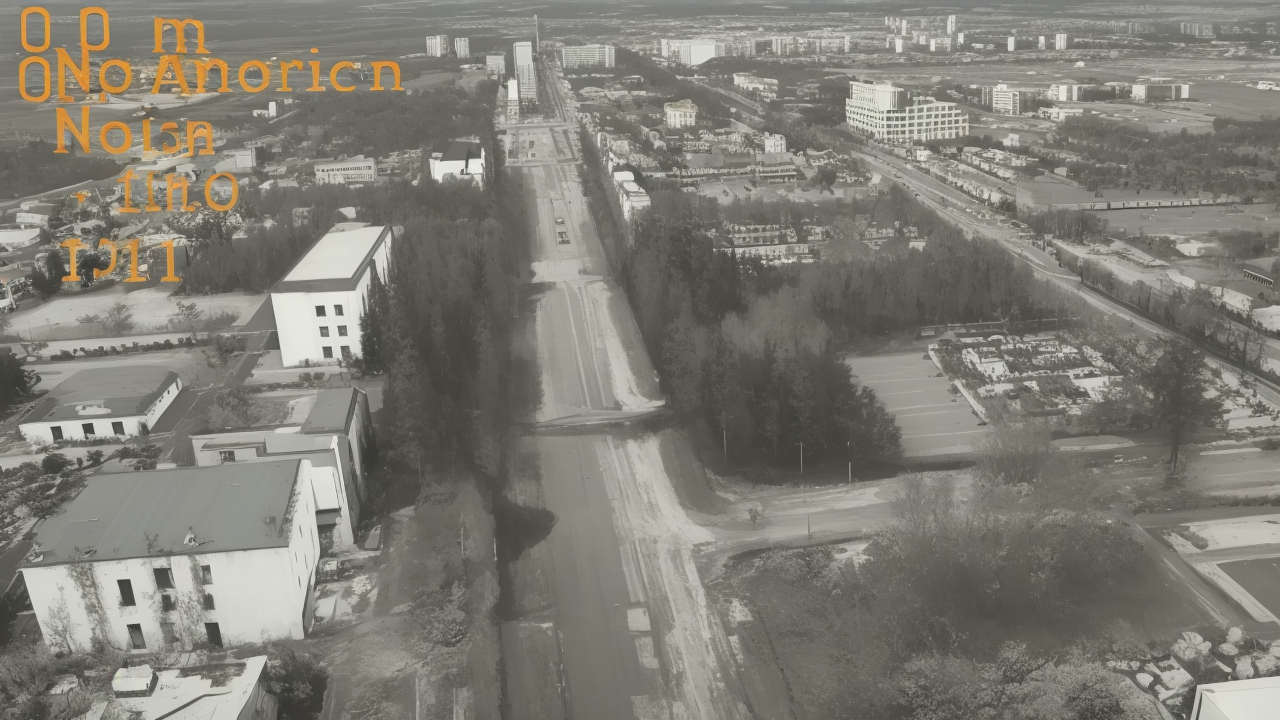

In [74]:
img2img_result.image

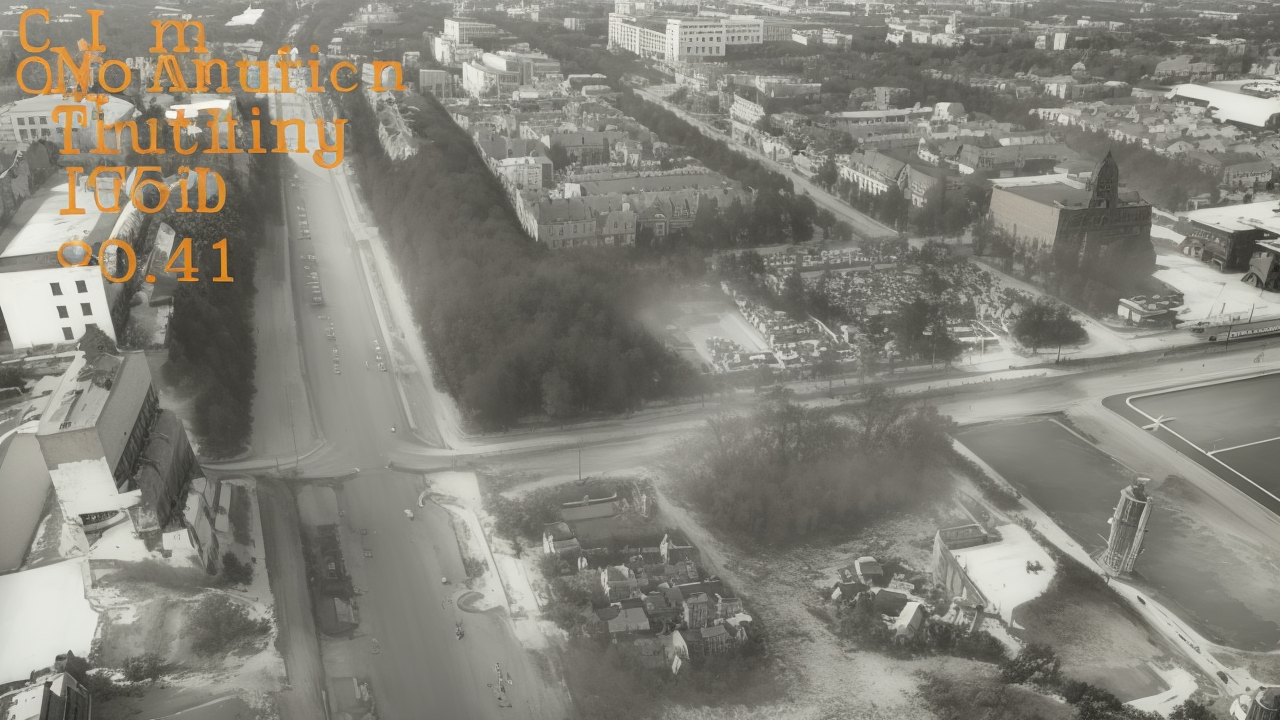

In [84]:
img2img_result.image

In [76]:
saving_folder = './result'
Path(saving_folder).mkdir(exist_ok=True)
img2img_result.image.save(saving_folder + f'/{(i+1):04}.png')

In [ ]:
flow21 = np.load(flo_path)
frame1pil = np.array(frame1.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))
frame1_warped21 = warp_flow(frame1pil, flow21)
# frame2pil = frame1pil
frame2pil = np.array(frame2.convert('RGB').resize((flow21.shape[1],flow21.shape[0])))

if weights_path: 
    forward_weights = load_cc(weights_path)
    blended_w = frame2pil*(1-blend) + blend*(frame1_warped21*forward_weights+frame2pil*(1-forward_weights))
else: blended_w = frame2pil*(1-blend) + frame1_warped21*(blend)

return  PIL.Image.fromarray(blended_w.astype('uint8'))

In [ ]:
from base64 import b64encode

latest_run = batchNum

folder = batch_name #@param
run = latest_run #@param
final_frame = 'final_frame'

blend_mode = "optical flow" #@param ['None', 'linear', 'optical flow']
if (blend_mode == "optical flow") & (animation_mode != 'Video Input'):
  print('Please enable Video Input mode and generate optical flow maps to use optical flow blend mode')
blend =  0.5#@param {type: 'number'}
check_consistency = True #@param {type: 'boolean'}


init_frame = 1#@param {type:"number"} This is the frame where the video will start
last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
fps = 12#@param {type:"number"}
# view_video_in_cell = True #@param {type: 'boolean'}


frames = []

if (blend_mode == 'optical flow') & (animation_mode == 'Video Input') :
    image_path = f"{outDirPath}/{folder}/flow/{folder}({run})_%04d.png"
    filepath = f"{outDirPath}/{folder}/{folder}({run})_flow.mp4"
    if last_frame == 'final_frame':
      last_frame = len(glob(batchFolder+f"/flow/{folder}({run})_*.png"))
    flo_out = batchFolder+f"/flow"
    !mkdir "{flo_out}"
    frames_in = sorted(glob(batchFolder+f"/{folder}({run})_*.png"))
    !cp "{frames_in[0]}" "{flo_out}"
    for i in trange(init_frame, min(len(frames_in), last_frame)):
      frame1_path = frames_in[i-1]
      frame2_path = frames_in[i]

      frame1 = PIL.Image.open(frame1_path)
      frame2 = PIL.Image.open(frame2_path)
      frame1_stem = f"{(int(frame1_path.split('/')[-1].split('_')[-1][:-4])+1):04}.jpg"
      flo_path = f"/{flo_folder}/{frame1_stem}.npy"
      weights_path = None
      if check_consistency: weights_path = f"/{flo_folder}/{frame1_stem}-21_cc.npy" 
      
      warp(frame1, frame2, flo_path, blend=blend, weights_path=weights_path).save(batchFolder+f"/flow/{folder}({run})_{i:04}.png")


In [119]:
!pip install webuiapi --upgrade

  Attempting uninstall: webuiapi
    Found existing installation: webuiapi 0.5.0
    Uninstalling webuiapi-0.5.0:
      Successfully uninstalled webuiapi-0.5.0



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
